In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [2]:
# Load the dataset (Descriptions for ICD code)
# Load the ICD dataset
icd = pd.read_csv('D_ICD_DIAGNOSES.csv.gz')  # Replace with your actual file name
icd.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [3]:
# Data types and non-null counts
icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       14567 non-null  int64 
 1   ICD9_CODE    14567 non-null  object
 2   SHORT_TITLE  14567 non-null  object
 3   LONG_TITLE   14567 non-null  object
dtypes: int64(1), object(3)
memory usage: 455.3+ KB


In [4]:

# Missing values
missing_values = icd.isnull().sum()
missing_values[missing_values > 0]

# Check duplicates
duplicates = icd.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')

# Drop duplicates
icd.drop_duplicates(inplace=True)

Total duplicate rows: 0


In [5]:
# Encode categorical column (SHORT_TITLE) to numerical code
icd['SHORT_TITLE_CODE'] = icd['SHORT_TITLE'].astype('category').cat.codes

# Scale a numeric column — here we use ROW_ID as a stand-in for HADM_ID
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
icd['ROW_ID_scaled'] = scaler.fit_transform(icd[['ROW_ID']])
icd[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,174,0.011877
1,175,0.011946
2,176,0.012014
3,177,0.012083
4,178,0.012152


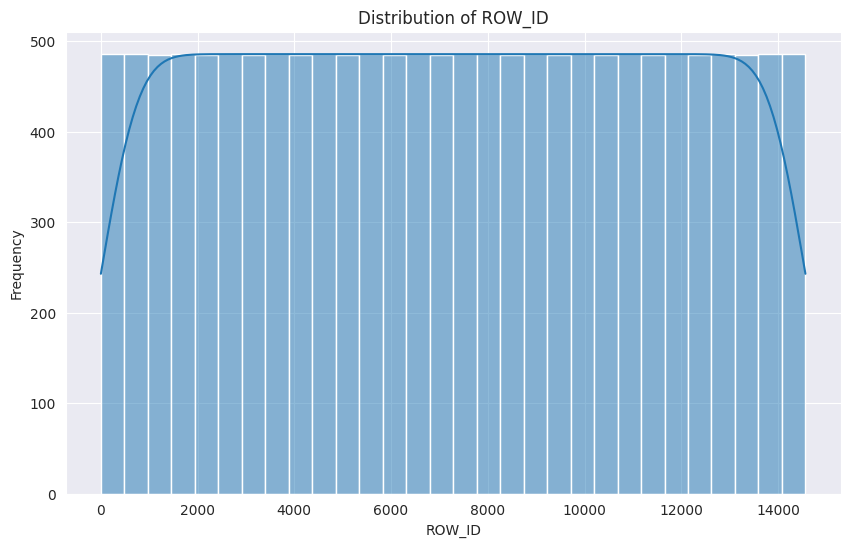

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(icd['ROW_ID'], kde=True, bins=30)
plt.title('Distribution of ROW_ID')
plt.xlabel('ROW_ID')
plt.ylabel('Frequency')
plt.show()


In [7]:
icd.to_csv('icd_cleaned.csv', index=False)


In [8]:

!pip install sdv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Fix multiprocessing issues
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Load cleaned data
icd_cleaned = pd.read_csv("icd_cleaned.csv")


In [10]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(icd_cleaned)

synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(icd_cleaned)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
ICD9_CODE              14567
SHORT_TITLE            14328
LONG_TITLE             14562
SHORT_TITLE_CODE       11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.14 GiB. GPU 0 has a total capacity of 23.66 GiB of which 1.19 GiB is free. Process 1057776 has 314.00 MiB memory in use. Process 1078468 has 560.00 MiB memory in use. Process 1090717 has 310.00 MiB memory in use. Process 1165899 has 3.12 GiB memory in use. Process 1202020 has 634.00 MiB memory in use. Process 1191989 has 5.02 GiB memory in use. Process 1203679 has 6.77 GiB memory in use. Process 1241728 has 4.88 GiB memory in use. Including non-PyTorch memory, this process has 292.00 MiB memory in use. Of the allocated memory 85.39 MiB is allocated by PyTorch, and 4.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_icd.csv", index=False)
synthetic_data.head()


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,SHORT_TITLE_CODE,ROW_ID_scaled
0,664342,sdv-pii-6iuxx,sdv-pii-2q64w,sdv-pii-ki66c,7123,0.479093
1,16443932,sdv-pii-lao3f,sdv-pii-ojbox,sdv-pii-mov9a,4637,0.499064
2,15754579,sdv-pii-s6vbe,sdv-pii-6li8c,sdv-pii-z7j8f,3950,0.633424
3,7123317,sdv-pii-qtl5w,sdv-pii-73f5y,sdv-pii-7tpyx,14327,0.056569
4,7447386,sdv-pii-1921c,sdv-pii-mffop,sdv-pii-q652q,1463,0.467715


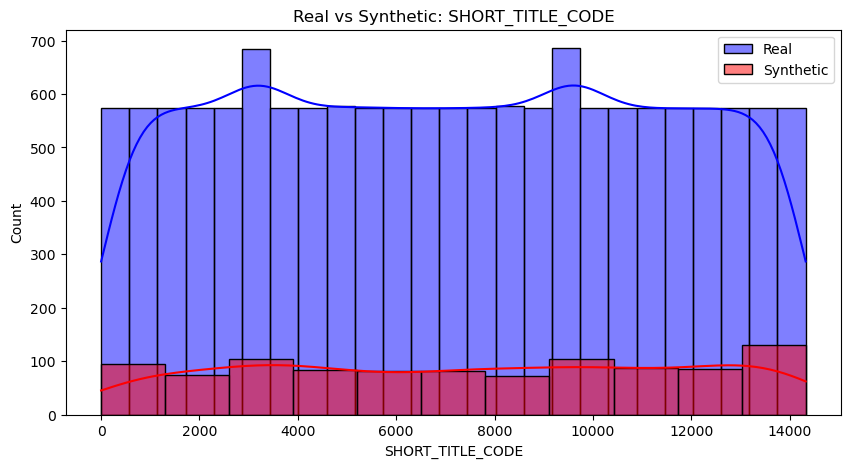

In [24]:
plt.figure(figsize=(10,5))
column = 'SHORT_TITLE_CODE'

sns.histplot(icd_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [25]:
# Create a fake binary target column for demonstration
icd_cleaned['TARGET'] = (icd_cleaned['ICD9_CODE'].astype(str).str.startswith('0')).astype(int)
synthetic_data['TARGET'] = (synthetic_data['ICD9_CODE'].astype(str).str.startswith('0')).astype(int)

features = ['SHORT_TITLE_CODE', 'ROW_ID_scaled']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = icd_cleaned[features]
y_real = icd_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data:{syn_acc:.2f}")


 Model accuracy on real data:     1.00
 Model accuracy on synthetic data:1.00


In [ ]:
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['SHORT_TITLE_CODE', 'ROW_ID_scaled']
target_col = 'LONG_TITLE'

# Create binary classification target
icd_cleaned['target'] = (icd_cleaned[target_col] > icd_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(icd_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(icd_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > icd_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    icd_cleaned[col] = icd_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = icd_cleaned[features]
y_real = icd_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")


In [1]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'real_acc' is not defined